In [1]:
%matplotlib inline
#%matplotlib notebook
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Disable auto scrolling

In [131]:

%%#javascript
#IPython.OutputArea.prototype._should_scroll = function(lines) {
#    return false;
#}

E0921 10:56:57.278982 140734820103616 interactiveshell.py:2090] Cell magic `%%#javascript` not found.


In [4]:
# Load and prepare data
array_reloaded = np.load("../VertexAndTracksCollection_n10_p200.npz")
tracks = array_reloaded["trackCollection"]#[:1000]
vertices = array_reloaded["vertexCollection"]#[:1000]

In [5]:
# Debug print outs
eventIdx = 9
print("Event {} with {} tracks and {} vertices.".format(eventIdx,tracks[eventIdx].shape[0],vertices[eventIdx].shape[0]))

Event 9 with 2767 tracks and 219 vertices.


In [6]:
def plot2d():
    # 2D plots
    for eventIdx in range(9,10):
        print("Event {} with {} tracks and {} vertices.".format(eventIdx,tracks[eventIdx].shape[0],vertices[eventIdx].shape[0]))
        evTrks = tracks[eventIdx]
        labels = ["d0", "z0", "phi", "theta", "q/p", "vtxIdx"]
        d0z0s = evTrks #d0, z0, phi, theta, q/p, vtxIdx

        for i in range(len(labels) - 1):
            for j in range(i+1, len(labels) - 1):

                xidx = i #+ offset
                yidx = j #+ offset

                xlabel = labels[xidx]
                ylabel = labels[yidx]

                #fig = plt.figure(figsize=(8, 6))
                plt.scatter(d0z0s[:,xidx], d0z0s[:,yidx],  c=d0z0s[:,-1],  cmap="gist_rainbow", s=10)

                plt.title('{}/{} track distribution colored by vtx'.format(ylabel, xlabel))
                plt.xlabel(xlabel)
                plt.ylabel(ylabel)

                plt.show()

In [7]:
def plot3d():
    # 3D plots
    for eventIdx in range(9,10):
        print("Event {} with {} tracks and {} vertices.".format(eventIdx,tracks[eventIdx].shape[0],vertices[eventIdx].shape[0]))
        evTrks = tracks[eventIdx]
        labels = ["d0", "z0", "phi", "theta", "q/p", "vtxIdx"]
        d0z0s = evTrks #d0, z0, phi, theta, q/p, vtxIdx

        for i in range(len(labels) - 1):
            for j in range(i+1, len(labels) - 1):
                for k in range(j+1, len(labels) - 1):
                    xidx = i #+ offset
                    yidx = j #+ offset
                    zidx = k

                    xlabel = labels[xidx]
                    ylabel = labels[yidx]
                    zlabel = labels[zidx]

                    fig = plt.figure(figsize=(8, 6))
                    ax = fig.add_subplot(111, projection='3d')
                    ax.scatter(d0z0s[:,xidx], d0z0s[:,yidx], d0z0s[:,zidx],  c=d0z0s[:,-1],  cmap="gist_rainbow", s=10)

                    plt.title('{}/{}/{} track distribution colored by vtx'.format(ylabel, xlabel, zlabel))
                    plt.xlabel(xlabel)
                    plt.ylabel(ylabel)
                    #plt.zlabel(zlabel)
                    plt.show()

In [9]:
##################
# Create binning #
##################
# Define bin sizes/resolutions for each trk parameter
d0BinSize = 0.1 #mm = 100micrometer
z0BinSize = 0.1 #mm = 100micrometer
phBinSize = 2*np.pi / 64
thBinSize = np.pi / 32
qpBinSize = 0.1
# Define ranges min/max
d0MinMax = -1, 1 #mm
z0MinMax = -150, 150 #mm
phMinMax = -np.pi, np.pi
thMinMax = 0, np.pi
qpMinMax = -3, 3
# Calculate number of needed bins
nBinsD0 = int((d0MinMax[1]-d0MinMax[0]) / d0BinSize)
nBinsZ0 = int((z0MinMax[1]-z0MinMax[0]) / z0BinSize)
nBinsPh = int((phMinMax[1]-phMinMax[0]) / phBinSize)
nBinsTh = int((thMinMax[1]-thMinMax[0]) / thBinSize)
nBinsQp = int((qpMinMax[1]-qpMinMax[0]) / qpBinSize)

# Returns the 5-d bin the current track falls into
def find5DBin(params):
    d0Bin = int(np.floor((params[0] + (nBinsD0*d0BinSize)/ 2) / d0BinSize))
    z0Bin = int(np.floor((params[1] + (nBinsZ0*z0BinSize)/ 2) / z0BinSize))
    phBin = int(np.floor((params[2] + (nBinsPh*phBinSize)/ 2) / phBinSize))
    thBin = int(np.floor((params[3]) / thBinSize))
    qpBin = int(np.floor((params[4] + (nBinsQp*qpBinSize)/ 2) / qpBinSize))
    
    return d0Bin, z0Bin, phBin, thBin, qpBin

def findD0Z0Bin(params):
    d0Bin = int(np.floor((params[0] + (nBinsD0*d0BinSize)/ 2) / d0BinSize))
    z0Bin = int(np.floor((params[1] + (nBinsZ0*z0BinSize)/ 2) / z0BinSize))
    
    return d0Bin, z0Bin

fullParamGrid = np.zeros([nBinsD0, nBinsZ0, nBinsPh, nBinsTh, nBinsQp])
z0d0ParamGrid = np.zeros([nBinsD0, nBinsZ0])

In [10]:
# Reset the grid to zeros
z0d0ParamGrid = np.zeros([nBinsD0, nBinsZ0])

In [28]:
# Reset grid to zeros
fullParamGrid = np.zeros([nBinsD0, nBinsZ0, nBinsPh, nBinsTh, nBinsQp])
eventIdx = 0
for i,trk in enumerate(tracks[eventIdx]):
    my5DBin = find5DBin(trk)
    my2DBin = findD0Z0Bin(trk)
    
    fullParamGrid[my5DBin] = trk[-1] + 1
    z0d0ParamGrid[my2DBin] = 1#trk[-1] + 1



In [29]:
z = z0d0ParamGrid[:,1250:1750]

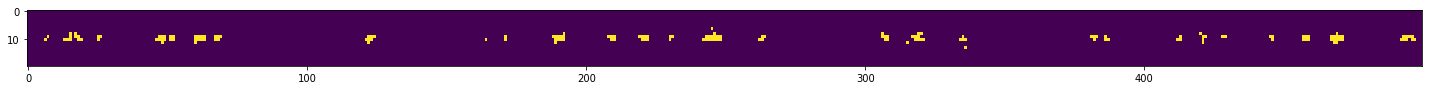

In [30]:
fig = plt.figure(figsize=(25,5))
plt.imshow(z)
plt.show()